In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
from PIL import Image
import os

def get_image_sizes(directory):
    image_widths = []
    image_heights = []

    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.gif')):  # Add more extensions if needed
            file_path = os.path.join(directory, filename)
            with Image.open(file_path) as img:
                width, height = img.size
                image_widths.append(width)
                image_heights.append(height)

    return image_widths, image_heights

directory_path = '/Users/sathwick/SDrive/work/pest-detection/data/IP102_YOLOv5/images/train'
image_widths, image_heights = get_image_sizes(directory_path)


(200.0, 800.0)

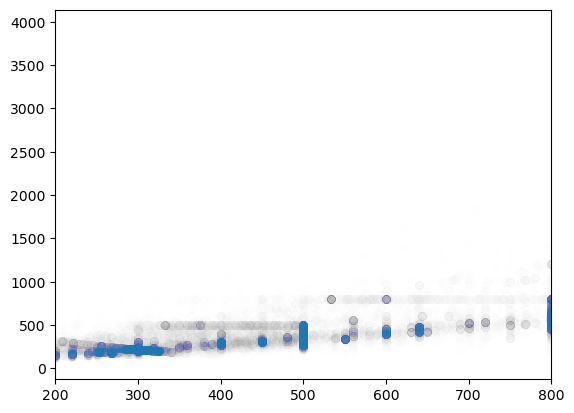

In [36]:
plt.scatter(image_widths, image_heights, alpha=0.002)
plt.xlim(200, 800)

In [71]:
from PIL import Image, ImageDraw

image = Image.open('/Users/sathwick/SDrive/work/pest-detection/data/IP102_YOLOv5/images/train/IP000000002.jpg')
image = image.resize((300, 300))
img_draw = ImageDraw.Draw(image)

target_size = image.size
x_center, y_center, width, height = 0.31, 0.43833333333333335, 0.355, 0.4766666666666667
x_min = (x_center - width / 2) * target_size[0]
y_min = (y_center - height / 2) * target_size[1]
x_max = (x_center + width / 2) * target_size[0]
y_max = (y_center + height / 2) * target_size[1]

img_draw.rectangle([x_min, y_min, x_max, y_max], outline='red', width=2)
        
image.show()

In [344]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Input layer
input_shape = (304, 304, 3)  # Assuming RGB images
input_img = Input(shape=input_shape)

# Encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Output layer with 3 channels for RGB

# Autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.summary()


Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 304, 304, 3)]     0         
                                                                 
 conv2d_111 (Conv2D)         (None, 304, 304, 64)      1792      
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 152, 152, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_112 (Conv2D)         (None, 152, 152, 128)     73856     
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 76, 76, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_113 (Conv2D)         (None, 76, 76, 256)       295

In [104]:
import tensorflow as tf

In [366]:
image = tf.io.read_file('/Users/sathwick/SDrive/work/pest-detection/data/IP102_YOLOv5/images/train/IP000000000.jpg')
image = tf.image.decode_jpeg(image, channels=3)

In [367]:
noise_img = tf.image.resize(image, [304, 304]).numpy()/255 + np.random.normal(scale=0.1, size=(304, 304, 3))

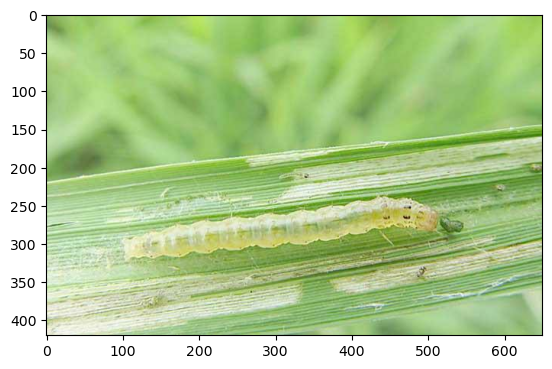

In [227]:
plt.plot()
plt.imshow(image)

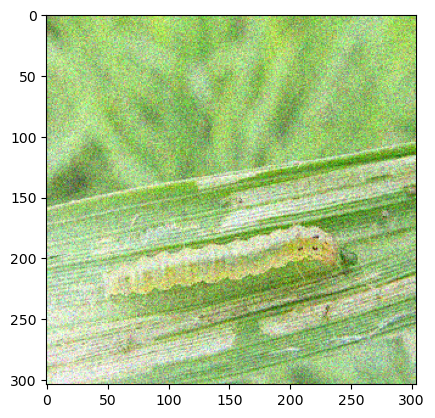

In [228]:
plt.plot()
plt.imshow(np.clip(noise_img, 0., 1.))

In [156]:
import math

In [355]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x_arr, batch_size=32, shuffle=True):
        # x_arr: Image file paths
        
        self.x_arr = x_arr
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.x_arr))
        np.random.shuffle(self.indexes)
        
    def preprocess_images(self, x_arr, noise):
        images = []
        max_shape = [1, 1]
        for image in x_arr:
            image = tf.io.read_file(image)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, [304, 304]).numpy()/255
            if noise:
                image += np.random.normal(scale=0.1, size=(304, 304, 3))
                image = np.clip(image, 0., 1.)
            images.append(image)
        
        X = np.array(images)
        return X
            
        
    def __getitem__(self, index):
        index = int(index)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = self.preprocess_images(self.x_arr[indexes], True)
        y = self.preprocess_images(self.x_arr[indexes], False)
        
        return X, y
    
    def __len__(self):
        return math.floor(len(self.x_arr) / self.batch_size)
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [380]:
data_gen = DataGenerator(np.array(train_image_files))

In [207]:
import os

directory_path = '/Users/sathwick/SDrive/work/pest-detection/data/IP102_YOLOv5/images/val'

# Get the list of files in the directory
file_list = os.listdir(directory_path)
file_list = list(map(lambda x: '/Users/sathwick/SDrive/work/pest-detection/data/IP102_YOLOv5/images/val/' + x, file_list))

In [359]:
dg = DataGenerator(np.array(file_list))

In [360]:
steps_per_epoch = len(dg)

In [361]:
steps_per_epoch

41

In [210]:
history = autoencoder.fit(dg, epochs=3, steps_per_epoch=steps_per_epoch)

Epoch 1/3
41/41 [==============================] - 278s 7s/step - loss: 0.0340
Epoch 2/3
41/41 [==============================] - 306s 7s/step - loss: 0.0111
Epoch 3/3
41/41 [==============================] - 348s 8s/step - loss: 0.0072


In [230]:
noise_img.shape

(304, 304, 3)

In [233]:
predict_img = autoencoder.predict(np.array([noise_img]))

1/1 [==============================] - 0s 69ms/step


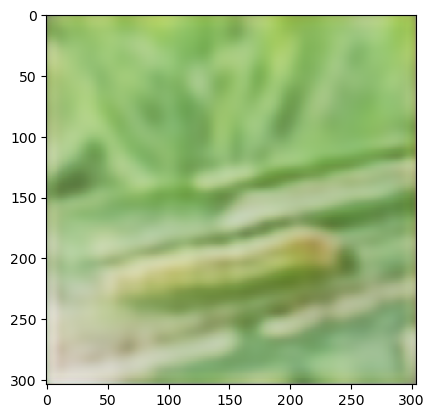

In [235]:
plt.imshow(predict_img[0])

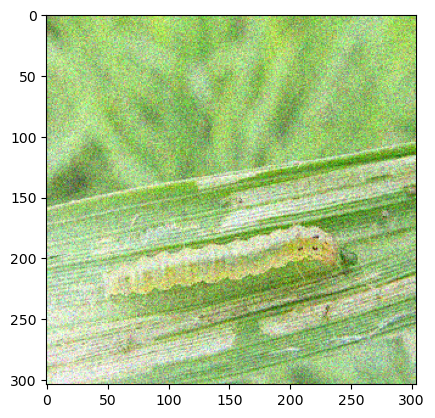

In [236]:
plt.imshow(noise_img)

In [49]:
import os

In [50]:
# Class: List of filenames

train_class_d = {k:[] for k in range(102)}

train_directory_path = '/Users/sathwick/SDrive/work/pest-detection/data/IP102_YOLOv5/labels/train'

train_files_list = os.listdir(train_directory_path)

for file in train_files_list:
    with open(train_directory_path + '/' + file, 'r') as cur_file:
        lines = cur_file.readlines()
        if len(lines) >= 2:
            continue
        cls = lines[0].split()[0]
        train_class_d[int(cls)].append(train_directory_path + '/' + file)

In [51]:
# Class: List of filenames

val_class_d = {k:[] for k in range(102)}

val_directory_path = '/Users/sathwick/SDrive/work/pest-detection/data/IP102_YOLOv5/labels/val'

val_files_list = os.listdir(val_directory_path)

for file in val_files_list:
    with open(val_directory_path + '/' + file, 'r') as cur_file:
        lines = cur_file.readlines()
        if len(lines) >= 2:
            continue
        cls = lines[0].split()[0]
        val_class_d[int(cls)].append(val_directory_path + '/' + file)

In [52]:
complete_class_d = {}

for i in range(102):
    complete_class_d[i] = train_class_d[i] + val_class_d[i]

In [304]:
80 * 10 * 0.8

640.0

In [53]:
import random

In [54]:
classes_map = {3: 0, 15: 1, 24: 2, 39: 3, 45: 4, 51: 5, 67: 6, 70: 7, 86: 8, 101: 9}

classes = {
    3: 'asiatic rice borer', 
    15: 'mole cricket', 
    24: 'aphids', 
    39: 'beet army worm', 
    45: 'flax budworm', 
    51: 'blister beetle', 
    67: 'Lycorma delicatula', 
    70: 'Miridae', 
    86: 'Prodenia litura', 
    101: 'Cicadellidae'
}

seed_value = 42
random.seed(seed_value)

subset_classes_files = {}
for i in classes:
    subset_classes_files[classes_map[i]] = random.sample(complete_class_d[i], 80)

In [55]:
classes.values()

dict_values(['asiatic rice borer', 'mole cricket', 'aphids', 'beet army worm', 'flax budworm', 'blister beetle', 'Lycorma delicatula', 'Miridae', 'Prodenia litura', 'Cicadellidae'])

In [56]:
subset_classes_label_files = subset_classes_files.copy()
subset_classes_image_files = subset_classes_files.copy()

for i in subset_classes_image_files:
    subset_classes_image_files[i] = list(map(lambda x: x.replace('labels', 'images').replace('.txt', '.jpg'), subset_classes_image_files[i]))

In [57]:
for i in subset_classes_label_files:
    for file in subset_classes_label_files[i]:
        with open(file, 'r+') as f:
            content = f.readline().split()
            content[0] = str(classes_map[int(content[0])])
            f.seek(0)
            f.write(' '.join(content))

In [58]:
train_image_files = []
val_image_files = []
test_image_files = []

train_label_files = []
val_label_files = []
test_label_files = []


for i in subset_classes_image_files:
    train_image_files.extend(subset_classes_image_files[i][:64])
    val_image_files.extend(subset_classes_image_files[i][64:72])
    test_image_files.extend(subset_classes_image_files[i][72:])

for i in subset_classes_label_files:
    train_label_files.extend(subset_classes_label_files[i][:64])
    val_label_files.extend(subset_classes_label_files[i][64:72])
    test_label_files.extend(subset_classes_label_files[i][72:])

In [354]:
DataGenerator(np.array([train_image_files]))

In [363]:
train_gen = DataGenerator(np.array(train_image_files))
val_gen = DataGenerator(np.array(val_image_files))
test_gen = DataGenerator(np.array(test_image_files))

In [364]:
steps_per_epoch = len(train_gen)
validation_steps = len(val_gen)

In [365]:
history = autoencoder.fit(train_gen, epochs=10, steps_per_epoch=steps_per_epoch, validation_data=val_gen, validation_steps=validation_steps)

Epoch 1/10
20/20 [==============================] - 149s 7s/step - loss: 0.0524 - val_loss: 0.0255
Epoch 2/10
20/20 [==============================] - 152s 8s/step - loss: 0.0212 - val_loss: 0.0175
Epoch 3/10
20/20 [==============================] - 152s 8s/step - loss: 0.0149 - val_loss: 0.0109
Epoch 4/10
20/20 [==============================] - 170s 8s/step - loss: 0.0101 - val_loss: 0.0098
Epoch 5/10
20/20 [==============================] - 174s 9s/step - loss: 0.0081 - val_loss: 0.0071
Epoch 6/10
20/20 [==============================] - 174s 9s/step - loss: 0.0067 - val_loss: 0.0064
Epoch 7/10
20/20 [==============================] - 174s 9s/step - loss: 0.0061 - val_loss: 0.0051
Epoch 8/10
20/20 [==============================] - 183s 9s/step - loss: 0.0057 - val_loss: 0.0057
Epoch 9/10
20/20 [==============================] - 183s 9s/step - loss: 0.0053 - val_loss: 0.0046
Epoch 10/10
20/20 [==============================] - 182s 9s/step - loss: 0.0049 - val_loss: 0.0048


In [395]:
history2 = autoencoder.fit(train_gen, epochs=10, steps_per_epoch=steps_per_epoch, validation_data=val_gen, validation_steps=validation_steps)

Epoch 1/10
20/20 [==============================] - 152s 8s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 2/10
20/20 [==============================] - 153s 8s/step - loss: 0.0044 - val_loss: 0.0039
Epoch 3/10
20/20 [==============================] - 154s 8s/step - loss: 0.0052 - val_loss: 0.0052
Epoch 4/10
20/20 [==============================] - 175s 9s/step - loss: 0.0045 - val_loss: 0.0044
Epoch 5/10
20/20 [==============================] - 181s 9s/step - loss: 0.0043 - val_loss: 0.0041
Epoch 6/10
20/20 [==============================] - 185s 9s/step - loss: 0.0041 - val_loss: 0.0037
Epoch 7/10
20/20 [==============================] - 174s 9s/step - loss: 0.0039 - val_loss: 0.0033
Epoch 8/10
20/20 [==============================] - 167s 8s/step - loss: 0.0039 - val_loss: 0.0034
Epoch 9/10
20/20 [==============================] - 178s 9s/step - loss: 0.0037 - val_loss: 0.0038
Epoch 10/10
20/20 [==============================] - 176s 9s/step - loss: 0.0037 - val_loss: 0.0038


In [420]:
save_best_cb = keras.callbacks.ModelCheckpoint('./autoencoder/checkpoint', save_best_only=True) # Saves the best model so far
stop_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [421]:
history3 = autoencoder.fit(train_gen, epochs=30, steps_per_epoch=steps_per_epoch, validation_data=val_gen, validation_steps=validation_steps, callbacks=[save_best_cb, stop_cb])

Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 0.0036INFO:tensorflow:Assets written to: ./autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ./autoencoder/checkpoint/assets


20/20 [==============================] - 151s 8s/step - loss: 0.0036 - val_loss: 0.0035
Epoch 2/30
20/20 [==============================] - 162s 8s/step - loss: 0.0035 - val_loss: 0.0041
Epoch 3/30
20/20 [==============================] - 180s 9s/step - loss: 0.0044 - val_loss: 0.0036
Epoch 4/30
20/20 [==============================] - ETA: 0s - loss: 0.0039INFO:tensorflow:Assets written to: ./autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ./autoencoder/checkpoint/assets


20/20 [==============================] - 181s 9s/step - loss: 0.0039 - val_loss: 0.0035
Epoch 5/30
20/20 [==============================] - ETA: 0s - loss: 0.0035INFO:tensorflow:Assets written to: ./autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ./autoencoder/checkpoint/assets


20/20 [==============================] - 193s 10s/step - loss: 0.0035 - val_loss: 0.0033
Epoch 6/30
20/20 [==============================] - ETA: 0s - loss: 0.0034INFO:tensorflow:Assets written to: ./autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ./autoencoder/checkpoint/assets


20/20 [==============================] - 183s 9s/step - loss: 0.0034 - val_loss: 0.0029
Epoch 7/30
20/20 [==============================] - 178s 9s/step - loss: 0.0035 - val_loss: 0.0034
Epoch 8/30
20/20 [==============================] - 177s 9s/step - loss: 0.0033 - val_loss: 0.0032
Epoch 9/30
20/20 [==============================] - 176s 9s/step - loss: 0.0033 - val_loss: 0.0029
Epoch 10/30
20/20 [==============================] - 178s 9s/step - loss: 0.0032 - val_loss: 0.0030
Epoch 11/30
20/20 [==============================] - 179s 9s/step - loss: 0.0033 - val_loss: 0.0031


In [3]:
import keras

In [4]:
best_model = keras.models.load_model('./autoencoder/checkpoint/')

In [ ]:
best_moe

In [376]:
image = tf.io.read_file('/Users/sathwick/SDrive/work/pest-detection/data/IP102_YOLOv5/images/train/IP003000866.jpg')
image = tf.image.decode_jpeg(image, channels=3)

noise_img = tf.image.resize(image, [304, 304]).numpy()/255 + np.random.normal(scale=0.1, size=(304, 304, 3))

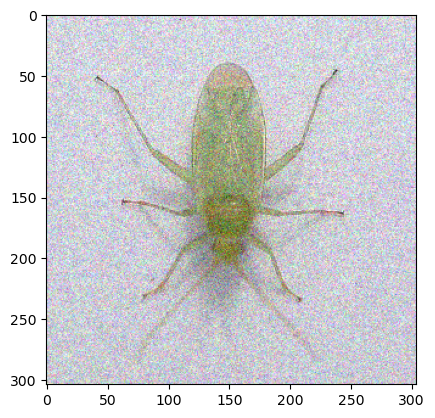

In [392]:
plt.plot()
plt.imshow(data_gen[0][0][0])

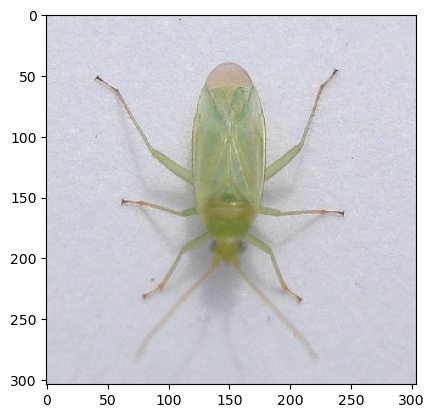

In [394]:
plt.imshow(data_gen[0][1][0])

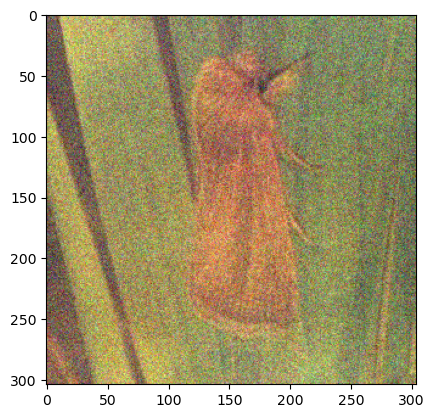

In [399]:
plt.imshow(noise_img)

In [424]:
predict_img = best_model.predict(np.array([noise_img]))

1/1 [==============================] - 0s 112ms/step


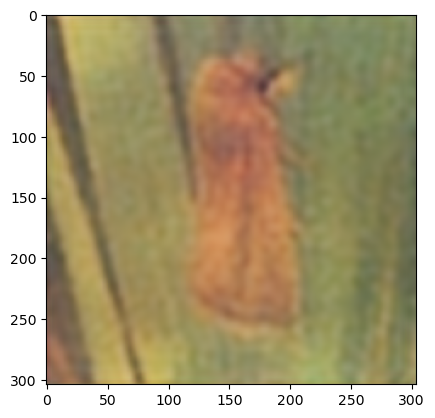

In [425]:
plt.imshow(predict_img[0])

In [416]:
import pickle

In [417]:
# with open('./autoencoder/history1', 'wb') as history_file:
#     pickle.dump(history.history, history_file)

In [418]:
# with open('./autoencoder/history2', 'wb') as history_file:
#     pickle.dump(history2.history, history_file)

In [422]:
# with open('./autoencoder/history3', 'wb') as history_file:
#     pickle.dump(history3.history, history_file)

In [419]:
# autoencoder.save('./autoencoder/best_model.keras')

In [ ]:
best_model = YOLO('/content/runs/detect/train/weights/best.pt')

im = Image.open('/content/drive/MyDrive/pest_detection/custom_yolo/images/val/IP003000154.jpg')
results = best_model.predict(source=im, save=True)

In [9]:
import numpy as np
import tensorflow as tf

In [10]:
def add_noise(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [304, 304]).numpy()/255
    image += np.random.normal(scale=0.1, size=(304, 304, 3))
    image = np.clip(image, 0., 1.)
    
    return image

In [19]:
predict_img = best_model.predict(np.array([add_noise('/Users/sathwick/SDrive/work/pest-detection/data/IP102_YOLOv5/images/val/IP003000154.jpg')]))

1/1 [==============================] - 0s 72ms/step


In [16]:
from ultralytics import YOLO

In [32]:
plt.imsave('output_image.jpg', predict_img[0])

In [43]:
y_model = YOLO('./data/best.pt')

im = Image.open('./output_image.jpg')
# im = Image.fromarray(predict_img[0])
results = y_model.predict(source=im, conf=0.5)


0: 320x320 1 asiatic rice borer, 46.0ms
Speed: 5.1ms preprocess, 46.0ms inference, 7.5ms postprocess per image at shape (1, 3, 320, 320)


In [47]:
results[0].boxes.cls

tensor([0.])

In [64]:
results = y_model.predict(source='/Users/sathwick/SDrive/work/pest-detection/data/test/images/')


image 1/80 /Users/sathwick/SDrive/work/pest-detection/data/test/images/IP003000064.jpg: 224x320 1 asiatic rice borer, 48.1ms
image 2/80 /Users/sathwick/SDrive/work/pest-detection/data/test/images/IP003000156.jpg: 224x320 1 asiatic rice borer, 16.6ms
image 3/80 /Users/sathwick/SDrive/work/pest-detection/data/test/images/IP003000251.jpg: 256x320 1 asiatic rice borer, 26.0ms
image 4/80 /Users/sathwick/SDrive/work/pest-detection/data/test/images/IP003000504.jpg: 256x320 2 asiatic rice borers, 21.9ms
image 5/80 /Users/sathwick/SDrive/work/pest-detection/data/test/images/IP003000551.jpg: 224x320 1 Cicadellidae, 18.5ms
image 6/80 /Users/sathwick/SDrive/work/pest-detection/data/test/images/IP003000825.jpg: 256x320 1 asiatic rice borer, 19.4ms
image 7/80 /Users/sathwick/SDrive/work/pest-detection/data/test/images/IP003000866.jpg: 320x320 1 asiatic rice borer, 1 flax budworm, 21.9ms
image 8/80 /Users/sathwick/SDrive/work/pest-detection/data/test/images/IP003000979.jpg: 288x320 1 asiatic rice bo

image 69/80 /Users/sathwick/SDrive/work/pest-detection/data/test/images/IP087000690.jpg: 256x320 (no detections), 21.5ms
image 70/80 /Users/sathwick/SDrive/work/pest-detection/data/test/images/IP087000777.jpg: 224x320 1 flax budworm, 19.3ms
image 71/80 /Users/sathwick/SDrive/work/pest-detection/data/test/images/IP087001218.jpg: 224x320 1 Prodenia litura, 19.0ms
image 72/80 /Users/sathwick/SDrive/work/pest-detection/data/test/images/IP087001257.jpg: 256x320 1 beet army worm, 1 Prodenia litura, 19.8ms
image 73/80 /Users/sathwick/SDrive/work/pest-detection/data/test/images/IP102000277.jpg: 288x320 1 asiatic rice borer, 23.7ms
image 74/80 /Users/sathwick/SDrive/work/pest-detection/data/test/images/IP102000776.jpg: 192x320 1 Cicadellidae, 18.0ms
image 75/80 /Users/sathwick/SDrive/work/pest-detection/data/test/images/IP102001722.jpg: 320x224 1 Cicadellidae, 21.1ms
image 76/80 /Users/sathwick/SDrive/work/pest-detection/data/test/images/IP102002191.jpg: 192x320 1 Cicadellidae, 21.1ms
image 77/

In [75]:
results[0].path

'/Users/sathwick/SDrive/work/pest-detection/data/test/images/IP003000064.jpg'

In [68]:
test_labels = os.listdir('/Users/sathwick/SDrive/work/pest-detection/data/test/labels/')

In [88]:
ctr = 0
metrics = []

for result in results:
    with open(result.path.replace('images', 'labels').replace('jpg', 'txt'), 'r') as f:
        result_cls = result.boxes.cls
        cur_cls = int(f.readline().split()[0])
        metrics.append([result_cls, cur_cls])
        if cur_cls in result_cls:
            ctr += 1
        else:
            print(result_cls, cur_cls)

tensor([9.]) 0
tensor([7.]) 2
tensor([]) 2
tensor([8.]) 3
tensor([4.]) 3
tensor([4.]) 3
tensor([8.]) 4
tensor([3.]) 4
tensor([2.]) 4
tensor([0., 3.]) 4
tensor([3.]) 4
tensor([9.]) 5
tensor([1., 9.]) 7
tensor([]) 7
tensor([4.]) 8
tensor([4.]) 8
tensor([]) 8
tensor([4.]) 8
tensor([0.]) 9


In [93]:
left_out = {k: [] for k in range(10)}

for i in range(10):
    for x in subset_classes_image_files[i]:
        if x in [*train_image_files[i], val_image_files[i], test_image_files[i]]:
            continue
        left_out[i].append(x)

In [96]:
import shutil

left_out_list = []

for i in left_out:
    left_out_list.extend(left_out[i])

for i in left_out_list:
    shutil.copy(i, '/Users/sathwick/SDrive/work/pest-detection/data/test copy/images/')

In [97]:
left_out = {k: [] for k in range(10)}

for i in range(10):
    for x in subset_classes_label_files[i]:
        if x in [*train_label_files[i], val_label_files[i], test_label_files[i]]:
            continue
        left_out[i].append(x)

In [98]:
import shutil

left_out_list = []

for i in left_out:
    left_out_list.extend(left_out[i])

for i in left_out_list:
    shutil.copy(i, '/Users/sathwick/SDrive/work/pest-detection/data/test copy/labels/')

In [100]:
results_all = y_model.predict(source='/Users/sathwick/SDrive/work/pest-detection/data/test copy/images/', conf=0.5)


image 1/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000008.jpg: 192x320 1 asiatic rice borer, 29.5ms
image 2/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000022.jpg: 256x320 1 asiatic rice borer, 22.1ms
image 3/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000059.jpg: 192x320 1 asiatic rice borer, 16.4ms
image 4/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000064.jpg: 224x320 1 asiatic rice borer, 19.6ms
image 5/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000074.jpg: 224x320 1 asiatic rice borer, 21.1ms
image 6/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000085.jpg: 256x320 1 asiatic rice borer, 20.7ms
image 7/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000102.jpg: 320x320 1 flax budworm, 27.3ms
image 8/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000104

image 64/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000855.jpg: 256x320 1 asiatic rice borer, 22.8ms
image 65/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000857.jpg: 256x320 1 asiatic rice borer, 20.5ms
image 66/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000866.jpg: 320x320 1 flax budworm, 27.8ms
image 67/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000876.jpg: 256x320 1 asiatic rice borer, 23.3ms
image 68/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000890.jpg: 256x320 1 asiatic rice borer, 20.7ms
image 69/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000909.jpg: 320x320 1 asiatic rice borer, 26.0ms
image 70/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000979.jpg: 288x320 1 asiatic rice borer, 25.4ms
image 71/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP00

image 129/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001101.jpg: 224x320 1 mole cricket, 24.8ms
image 130/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001158.jpg: 224x320 1 mole cricket, 19.4ms
image 131/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001213.jpg: 160x320 1 mole cricket, 17.3ms
image 132/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001216.jpg: 224x320 1 mole cricket, 17.3ms
image 133/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001235.jpg: 224x320 1 mole cricket, 20.5ms
image 134/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001243.jpg: 256x320 1 mole cricket, 20.4ms
image 135/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001287.jpg: 224x320 1 mole cricket, 17.3ms
image 136/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001297.jpg: 256x320 1 mole 

image 196/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001520.jpg: 288x320 1 aphids, 21.4ms
image 197/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001525.jpg: 224x320 1 aphids, 23.2ms
image 198/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001526.jpg: 192x320 1 aphids, 16.2ms
image 199/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001535.jpg: 288x320 1 aphids, 21.8ms
image 200/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001582.jpg: 288x320 1 aphids, 22.2ms
image 201/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001668.jpg: 288x320 1 aphids, 19.5ms
image 202/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001695.jpg: 320x320 1 aphids, 25.1ms
image 203/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001697.jpg: 224x320 1 aphids, 19.6ms
image 204/799 /Users/sathwick/SD

image 263/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000317.jpg: 192x320 1 beet army worm, 14.5ms
image 264/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000334.jpg: 224x320 1 beet army worm, 18.7ms
image 265/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000348.jpg: 256x320 1 beet army worm, 19.2ms
image 266/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000349.jpg: 288x320 1 beet army worm, 24.0ms
image 267/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000361.jpg: 192x320 1 beet army worm, 17.1ms
image 268/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000376.jpg: 224x320 1 beet army worm, 23.2ms
image 269/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000382.jpg: 256x320 1 beet army worm, 20.1ms
image 270/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000394.jpg: 2

image 327/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000090.jpg: 256x320 1 flax budworm, 19.1ms
image 328/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000096.jpg: 288x320 1 flax budworm, 21.6ms
image 329/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000127.jpg: 256x320 1 flax budworm, 20.2ms
image 330/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000133.jpg: 224x320 1 flax budworm, 19.2ms
image 331/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000160.jpg: 224x320 1 flax budworm, 15.2ms
image 332/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000162.jpg: 224x320 1 flax budworm, 21.4ms
image 333/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000163.jpg: 320x320 1 flax budworm, 24.9ms
image 334/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000167.jpg: 256x320 1 flax 

image 392/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001022.jpg: 224x320 1 flax budworm, 19.4ms
image 393/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001027.jpg: 224x320 1 flax budworm, 19.4ms
image 394/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001029.jpg: 320x288 1 flax budworm, 22.8ms
image 395/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001032.jpg: 320x320 1 flax budworm, 24.4ms
image 396/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001036.jpg: 256x320 1 flax budworm, 19.7ms
image 397/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001046.jpg: 256x320 1 flax budworm, 20.8ms
image 398/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001060.jpg: 224x320 1 flax budworm, 20.9ms
image 399/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001063.jpg: 256x320 1 flax 

image 456/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001420.jpg: 256x320 1 blister beetle, 23.2ms
image 457/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001421.jpg: 224x320 1 blister beetle, 17.5ms
image 458/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001486.jpg: 320x224 1 blister beetle, 16.9ms
image 459/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001524.jpg: 288x320 1 blister beetle, 24.7ms
image 460/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001530.jpg: 256x320 1 blister beetle, 20.9ms
image 461/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001541.jpg: 320x192 1 blister beetle, 17.4ms
image 462/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001558.jpg: 224x320 1 blister beetle, 18.2ms
image 463/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001563.jpg: 3

image 519/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP068003289.jpg: 256x320 1 Lycorma delicatula, 20.6ms
image 520/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP068003363.jpg: 256x320 1 Lycorma delicatula, 19.7ms
image 521/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP068003415.jpg: 320x256 1 Lycorma delicatula, 22.4ms
image 522/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP068003424.jpg: 320x256 1 Lycorma delicatula, 17.9ms
image 523/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP068003597.jpg: 288x320 1 Lycorma delicatula, 21.6ms
image 524/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP068003601.jpg: 224x320 1 Cicadellidae, 19.8ms
image 525/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP068003602.jpg: 224x320 1 Lycorma delicatula, 17.2ms
image 526/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/ima

image 583/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071001747.jpg: 192x320 1 Miridae, 15.5ms
image 584/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071001778.jpg: 320x320 1 Miridae, 25.5ms
image 585/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071001864.jpg: 256x320 1 Miridae, 23.5ms
image 586/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071001988.jpg: 288x320 1 Miridae, 22.4ms
image 587/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071002056.jpg: 192x320 1 Miridae, 15.4ms
image 588/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071002128.jpg: 224x320 1 Miridae, 16.2ms
image 589/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071002192.jpg: 320x320 1 Miridae, 26.7ms
image 590/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071002239.jpg: 320x256 1 Miridae, 19.8ms
image 591/799 /Users/sat

image 650/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000241.jpg: 224x320 1 Prodenia litura, 17.1ms
image 651/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000258.jpg: 224x320 1 flax budworm, 14.2ms
image 652/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000284.jpg: 256x320 1 Prodenia litura, 19.7ms
image 653/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000288.jpg: 224x320 1 Prodenia litura, 16.6ms
image 654/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000310.jpg: 320x320 1 Prodenia litura, 22.1ms
image 655/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000350.jpg: 224x320 1 Prodenia litura, 16.8ms
image 656/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000356.jpg: 192x320 1 Prodenia litura, 14.2ms
image 657/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000392.jp

image 714/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087001178.jpg: 224x320 1 Prodenia litura, 19.1ms
image 715/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087001218.jpg: 224x320 1 Prodenia litura, 17.5ms
image 716/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087001227.jpg: 224x320 1 Prodenia litura, 23.8ms
image 717/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087001245.jpg: 256x320 1 Prodenia litura, 19.4ms
image 718/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087001254.jpg: 256x320 1 Prodenia litura, 18.4ms
image 719/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087001257.jpg: 256x320 1 beet army worm, 20.4ms
image 720/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102000125.jpg: 224x320 1 Cicadellidae, 17.5ms
image 721/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102000263.jpg

image 779/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102003896.jpg: 224x320 1 Cicadellidae, 15.7ms
image 780/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102004043.jpg: 256x320 1 Cicadellidae, 17.6ms
image 781/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102004078.jpg: 256x320 1 Cicadellidae, 18.2ms
image 782/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102004117.jpg: 256x320 1 Cicadellidae, 17.2ms
image 783/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102004225.jpg: 320x256 1 Cicadellidae, 16.1ms
image 784/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102004249.jpg: 320x224 1 Cicadellidae, 14.4ms
image 785/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102004292.jpg: 224x320 1 Cicadellidae, 16.8ms
image 786/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102004325.jpg: 320x320 1 Cicad

In [101]:
ctr = 0
metrics = []

for result in results_all:
    with open(result.path.replace('images', 'labels').replace('jpg', 'txt'), 'r') as f:
        result_cls = result.boxes.cls
        cur_cls = int(f.readline().split()[0])
        metrics.append([result_cls, cur_cls])
        if cur_cls in result_cls:
            ctr += 1
        else:
            print(result_cls, cur_cls)

tensor([4.]) 0
tensor([9.]) 0
tensor([4.]) 0
tensor([]) 2
tensor([9.]) 2
tensor([]) 2
tensor([7.]) 2
tensor([]) 2
tensor([]) 2
tensor([4.]) 2
tensor([5.]) 2
tensor([4.]) 3
tensor([8.]) 3
tensor([8.]) 3
tensor([4.]) 3
tensor([]) 3
tensor([4.]) 3
tensor([4.]) 3
tensor([4.]) 3
tensor([]) 4
tensor([3.]) 4
tensor([8.]) 4
tensor([0.]) 4
tensor([8.]) 4
tensor([3.]) 4
tensor([2.]) 4
tensor([0.]) 4
tensor([0.]) 4
tensor([]) 4
tensor([3.]) 4
tensor([8.]) 4
tensor([]) 5
tensor([]) 5
tensor([]) 5
tensor([9.]) 5
tensor([9.]) 6
tensor([]) 7
tensor([1.]) 7
tensor([1.]) 7
tensor([]) 7
tensor([]) 7
tensor([]) 7
tensor([]) 8
tensor([4.]) 8
tensor([3.]) 8
tensor([3.]) 8
tensor([4.]) 8
tensor([3.]) 8
tensor([]) 8
tensor([]) 8
tensor([4.]) 8
tensor([]) 8
tensor([4.]) 8
tensor([4.]) 8
tensor([3.]) 8
tensor([0.]) 9
tensor([7.]) 9
tensor([0.]) 9
tensor([2.]) 9


In [108]:
ctr/len(results_all) * 100

92.61576971214018